Rebecca Chandler

## Neural Network Project

A Neural Network implementation and training on a simple dataset.

1. [Short Description of Neural Networks](#overview)
2. [Project Description](#description)
3. [Implementation Code](#implemenation)
4. [Data Set](#dataset)
5. [Testing](#testing)
6. [Varying parameters: learning rate, decay rate, shape](#varying)
7. [Analysis](#analysis)
8. [Resources](#resources)

### Short Description of Neural Networks <a name="overview"></a>
A short overview to help understand the implementation steps.

**What is a Neural Network?**  A neural network is a complex machine learning tool that mimics the human brain and its functions.  It is structured as a collection of nodes (similar to neurons) that recieve incoming data signals and may then activate and send signals to other nodes.

The nodes in a neural network take on different structures and can make very different types of networks.  A __feed-forward network__ consists of one layer of input nodes (one for each input variable), one or more "hidden layers" with a custom number of nodes, and a final output later (one node for each output variable).  Each node feeds signals into every node in the subsequent layer.  In this way a network is considered "fully connected".


![alt text](./NeuralNetwork75.jpg "Feed-forward Neural Network Architecture")
<div style="text-align: right">*Feed-forward Neural Network Shape*</div>

**Node Functions:** When a node recieves a set of signals from the previous layer, it sums them together after first adjusting each variable according to the node's internal weights. These weights are determined when learning a model.  A bias value is added to this summation (*$z$*) too. The activation function (*$\phi$*) is then applied to this sum.

![alt text](./sigmoid_activation_function.png "Sigmoid Function")
<div style="text-align: right">*Sigmoid Function*</div>

This is the sigmoid activation function.  Input values are polarized to a positive or negative output value between 0 and 1.  The positive value would represent an active signal being triggered and sent to nodes in the next layer.

**Forward and Backward Propopgation:**
To recieve an output value from the network, given an input value, signals must be propgrated through the network from the first layer to the last.  This is called __forward propogation__.  The last layer might represent some decision, for example, (0,1) being positive for outcome \#1 and (1,0) positive for outcome \#2.  Discrete outcomes are usually given separate output variables.

The network can "learn" certain scenarios by adjusting the weights at each node.  Adjusting these numbers improves its sensitivity to certain data patterns.  The network readjusts itself for each new data sample it sees when training.

**How does training a network happen?**  For each training sample, after an output has been calculated with forward propogation, the errors for each weight are calculated through a process of __backward propogation__.  The error is the difference between the actual and expected output.  The error with respect to each weight is calculated by propogating the initial error backward through the network from the final layer to the first.  To determine the initial error, we first use a cost function to compare the actual and expected outputs.  The error at each weight is the derivative of the cost function with respect to that weight.  Once the per-weight errors are calculated, we adjust all the weights by some factor, for example, 7%.  This factor is called the __learning rate__.

Cross-entropy cost function:
<center>*$J(\theta) = -\frac{1}{N}\sum_{n=1}^{n}[y_{n}\log \hat{y}_{n} + (1-y_{n})\log (1-\hat{y}_{n})]$*</center>

Once we can train a network, we can then experiment with different learning rates and network shapes and compare results with a test set of data.

### Project Description <a name="description"></a>

**The neural network implemented here has the following characteristics:**
- feed-forward, fully connected
- user-defined shape (number of nodes at each layer)
- sigmoid activation functions
- cross-entropy cost function used for back-propogation
- Stochastic Gradient Descent (processes one sample at a time)

**Implementation steps:**

(Weights *$w$* from the diagram and code are represented as *$\theta$* in written equations.)

1. Randomly initialize weights
2. Implement forward propogation to get $h_{\theta}(x)$ for any $x$ (get result for any sample)
3. Implement back-propogation to compute partial derivatives $\dfrac{\partial }{\partial \theta_{ij}^{(l)}}J(\theta)$ with respect to each $\theta_{ij}^{(l)}$.  This determines how much each weight affects the cost function result, and thus how much we will adjust each weight as we train the network.  Adjustments are made with each training sample.
4. Check the correcness of the backpropogation implementation using *gradient checking*.
    1. Implement code to compute cost function $J(\theta)$
    2.  Compare $\dfrac{\partial }{\partial \theta_{ij}^{(l)}}J(\theta)$ computed using back-propogation vs using numerical estimate of gradient $J(w)$.
    3. Then disable gradient checking code.
5. Train a network on a collection of training data.
6. Predict by performing forward propogation on a sample

### Implementation <a name="implementation"></a>

In [122]:
import numpy as np

from math import exp
from math import log

class NeuralNetwork(object):
    
    def __init__(self, shape, learning_rate=0.07, decay_rate=0):
        """Instance vars: (created here)
            self.shape - array of nodes per layer
            self.layer_count - # layers
            self.weights - weights[layer][node1 in layer][node2 in layer+1]
            self.bias - bias[layer][node in layer+1]
    
        Params:
            shape - array of nodes per layer
                [input layer, hidden layer(s), ... , output layer]
        """
                
        self.reset(shape, learning_rate, decay_rate)
        
        
    def reset(self, shape=None, learning_rate=None, decay_rate=None):
        """Initialize weights and biases randomly.
        May also adjust learning rate, decay rate, and shape
        """
        
        # keep previous settings if none given
        if shape:
            self.shape = shape
        if learning_rate is not None:    
            self.learning_rate = learning_rate
        if decay_rate is not None:    
            self.decay_rate = decay_rate
            
        self.layer_count = len(self.shape)
        
        # randomly initialize weights for: weights[layer][node1][node2]
        # first init weights with dtype=np.ndarray because numpy will try to coerce a matrix if first two dimensions match
        self.weights = np.empty(self.layer_count-1, dtype=np.ndarray)
        for i in range(len(self.weights)):
            self.weights[i] = np.random.rand(self.shape[i],self.shape[i+1])
        
        self.bias = np.array([np.zeros(self.shape[x]) \
               for x in range(1,self.layer_count)])
      
        
    @staticmethod
    def sigmoid(z):
        """Sigmoid activation function"""
        return 1.0/(1 + np.exp(-z))
    
    
    def forward_prop(self, inputs):
        """Given a vector of inputs, propogate through the network to calculate an output
    
        Algorithm:
        z[1] = W[layer 1]*inputs + biases[layer 1]
        a[1] = sigmoid(z[1])
        z[2] = W[layer 2]*a[1] + biases[layer 2]
        ... and so on
   
        Returns: inputs matrix z[layer][node], outputs matrix a[layer][node]
        """
        
        # better readability
        weights = self.weights
        bias = self.bias
        layer_count = self.layer_count
        shape = self.shape
        
       
        nodes_z = np.array([np.zeros(x) for x in shape]) #format: nodes_z[layer]
        nodes_a = np.array([np.zeros(x) for x in shape]) #format: nodes_a[layer]
        nodes_z[0] = nodes_a[0] = inputs

        # z(l) = a(l-1)*W(l-1) + bias
        # a{l} = sigmoid(z{l})
        for layer in range(1,layer_count):
            #print "layer: %d, nodes_a: %d, weights: %d, bias: %d" % (layer, len(nodes_a[layer-1]),len(weights[layer-1]),len(bias[layer-1]))
            nodes_z[layer] = np.dot(nodes_a[layer-1], weights[layer-1]) + bias[layer-1]
            nodes_a[layer] = np.array([NeuralNetwork.sigmoid(z) for z in nodes_z[layer]])
        
        return nodes_z, nodes_a
    
    
    def back_prop(self, nodes_a, target):
        """Given forward-propogated calculations and an expected output, back-propogate the error 
        to find the error on each weight.  The error is the derivative of the cost function with 
        respect to each weight.

        Cost function: y[k]*log(hw[k]) + (1-y[k])*log(1-hw[k])
        "∙" indicates matrix dot product

        Algorithm:
        errors[last layer] = a[last layer] - expected output <--(this step directly incororpates the cost func derivative)

        for subsequent layers, moving toward first layer: <-- (these steps incorporate the derivative of the sigmoid function)
            errors[layer][node i] = sum(weight[layer][j][i] * errors[j]) for all nodes j in layer+1
                                    * sigmoid_derivative(a[layer][node i])
            So, errors[layer] = weights[layer](transpose) ∙ errors[layer+1] * sigmoid_derivative(a[layer])
                              = weights[layer](transpose) ∙ errors[layer+1] * (a[layer] * (1 - a[layer]))


        error_per_weight[layer][i][j] = a[layer][i] * errors[layer+1][j]
        So, error_per_weight[layer] = a[layer](transpose) ∙ errors[layer+1]

        (the error on each bias[layer][j] is simply errors[layer+1][j] because "a" is 1)

        Returns:
            errors[layer][node], error_per_weight[layer][i][j]"""
        
        # better readability
        weights = self.weights
        bias = self.bias
        layer_count = self.layer_count
        shape = self.shape
        
        
        errors = np.array([np.zeros(x) for x in shape]) #format: errors[layer]

        # first init error_matrix with dtype=np.ndarray because numpy will
        # try to coerce a matrix if first two dimensions match
        # format: error_matrix[layer][i][j]
        error_matrix = np.empty(self.layer_count-1, dtype=np.ndarray)
        for i in range(len(error_matrix)):
            error_matrix[i] = np.random.rand(shape[i],shape[i+1])
        
        # output layer
        # errors[layer_count-1] = (np.array(target) - nodes_a[layer_count-1]) \
        #                           * sigmoid_prime(nodes_a[layer_count-1]) # squared-error cost func
        errors[layer_count-1] = nodes_a[layer_count-1] - np.array(target) # cross-entropy cost func

        #hidden layers & input layer
        for layer in range(layer_count-2,-1,-1):
            errors[layer] = nodes_a[layer]*(1-nodes_a[layer]) * errors[layer+1].dot(weights[layer].T)

        #errors per weight
        for layer in range(layer_count-1):
            error_matrix[layer] = np.dot(np.array([nodes_a[layer]]).T, np.array([errors[layer+1]]))

        return errors, error_matrix
    
    
    def Jw(self, data, targets):
        """Cost function
        y[k]*log(hw[k]) + (1-y[k])*log(1-hw[k])
        
        Used in gradient checking.

        Params:
            data - an array of input vectors
            targets - array of expected outputs
        Returns:
            the the mean of per-entry costs"""

        sum = 0
        for m in range(0, len(data)):
            x = data[m]
            y = targets[m]

            nodes_z, nodes_a = self.forward_prop(x)
            hw = nodes_a[self.layer_count-1]
            for k in range(0,len(y)):
                sum += y[k]*log(hw[k]) + (1-y[k])*log(1-hw[k]) # cross-entropy cost func
                #sum += 0.5*(hw[k]-y[k])*(hw[k]-y[k]) # squared-error cost func

        return sum * -1.0/len(data)
    
    
    def gradientChecking(self, X, y):
        """A numerical approximation of the cost func with respect to each weight
        Used to verify that back-propagation is implemented correctly

        numericalGradient = (cost(w+epsilon) - cost(w-epsilon))/(2*epsilon), for each w"""
        
        # better readability
        weights = self.weights
        layer_count = self.layer_count
        shape = self.shape
        
        
        epsilon = 1e-4
        numgrad = np.array([np.zeros((shape[x],shape[x+1])) for x in range(0,layer_count-1)])
        # format: numgrad[layer][i][j]

        for layer in range(0,layer_count-1):
            for i in range(0, shape[layer]):
                for j in range(0,shape[layer+1]):
                    weight = weights[layer][i][j] # store the weight value before editing
                    weights[layer][i][j] = weight - epsilon
                    cost1 = self.Jw([X], [y]) # cost function references self.weights

                    weights[layer][i][j] = weight + epsilon
                    cost2 = self.Jw([X], [y])

                    weights[layer][i][j] = weight # restore the weight value

                    numgrad[layer][i][j] = (cost2-cost1)/(2*epsilon)

        return numgrad
    
    def updateWeights(self, error_matrix, errors):
        """Given errors per-weight and per-node, update weights and biases"""
        
        self.weights = self.weights - self.learning_rate*error_matrix \
                    - self.decay_rate * self.learning_rate*self.weights
        self.bias = self.bias + self.learning_rate*errors[1:]

        
    def learn(self, X, y, num_checkpoints=0):
        """Train the neural network on a set of inputs and outputs
        Processes one entry at a time & updates weights
        Params:
           X - array of input vectors
           y - array of expected outputs
           num_checkpoints - record the error found on this many equally-spaced training examples
                             (used to see how well the network is learning)
        Returns: array of recorded errors if num_checkpoints was given"""
        
        if num_checkpoints:
            if len(X) < num_checkpoints:
                num_checkpoints = len(X)
            sample_error = np.zeros(num_checkpoints)
            iters = len(X)/num_checkpoints
        
        for i in range(len(X)):
            nodes_z, nodes_a = self.forward_prop(X[i])
            errors, err_mat = self.back_prop(nodes_a, [y[i]])
            
            if num_checkpoints and (i%iters==0):
                sample_error[int(i/iters)] = errors[self.layer_count-1]
            
            self.updateWeights(err_mat, errors)
            
        if num_checkpoints:
            return sample_error
        
        
    def predict(self, X):
        """Predict outputs for a set of inputs
    
        Params: X - an array of input vectors
        Returns: an array of outputs"""
        
        outputs = np.zeros(len(X))
        for i in xrange(len(X)):
            z,a = self.forward_prop(X[i])
            outputs[i] = a[self.layer_count-1]
        return outputs
    
    @property
    def learning_rate(self):
        return self._learning_rate

    @learning_rate.setter
    def learning_rate(self, learning_rate):
        self._learning_rate = learning_rate
        
    @property
    def decay_rate(self):
        return self._decay_rate

    @learning_rate.setter
    def decay_rate(self, decay_rate):
        self._decay_rate = decay_rate


### The Iris Dataset: <a name="dataset"></a>
Import the Iris dataset to test our neural network.

We will aim to classify samples of Iris plants by their species: *setosa*, *versicolor*, or *virginica*.  Vector outputs should look something like [1,0,0] for setosa, [0,1,0] for versicolor, etc.

Each data sample (or input) includes four features (or parameters): sepal length, sepal width, petal length, and petal width.  These must be normalized between values of 0 and 1.

*Trouble performing gradient-checking on vector outputs.  For now, normalize the output to a single value.*

In [80]:
def normalize_integer_array_to_vector(target_integers, max_int=None):
    """Params:
        target_integers - an array of integers between 0 and max_int inclusive
        max_int - maximum value in target_integers
        
        Returns - array of vectors
                [1,0,0,0...] replaces 0
                [0,1,0,0...] replaces 1
                etc
    """
    if not max_int:
        max_int = max(target_integers)
    norm = [np.zeros(len(data.target_names)) for x in range(len(data.target))]
    for i in range(len(norm)):
        norm[i][data.target[i]] = 1
    return np.array(norm)

In [146]:
# Use the iris dataset
from sklearn.datasets import load_iris
data = load_iris()

from sklearn.preprocessing import normalize
iris_norm = {'data':normalize(data.data),
             # 'target':normalize_integer_array_to_vector(data.target.reshape(1,-1))}
             'target':normalize(data.target.reshape(1,-1))[0]}

print ("--------------- Features ---------------")
print ("feature names: ", data.feature_names)
print ("feature rows 0-5 of ", len(data.data), ":\n", data.data[0:5])
print ("feature rows 0-5 of ", len(data.data), " normalized:\n", iris_norm['data'][0:5])
print ("")
print ("--------------- Targets ---------------")
print ("target names: ", data.target_names)
print ("target values 0-5 of ", len(data.target), ": ", data.target[0:5])
print ("target values 0-5 of ", len(data.target), " normalized: ", iris_norm['target'][0:5])
print ("target values 145-150 of ", len(data.target), " normalized: ", iris_norm['target'][145:150])

--------------- Features ---------------
feature names:  ['sepal length (cm)', 'sepal width (cm)', 'petal length (cm)', 'petal width (cm)']
feature rows 0-5 of  150 :
 [[5.1 3.5 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.7 3.2 1.3 0.2]
 [4.6 3.1 1.5 0.2]
 [5.  3.6 1.4 0.2]]
feature rows 0-5 of  150  normalized:
 [[0.80377277 0.55160877 0.22064351 0.0315205 ]
 [0.82813287 0.50702013 0.23660939 0.03380134]
 [0.80533308 0.54831188 0.2227517  0.03426949]
 [0.80003025 0.53915082 0.26087943 0.03478392]
 [0.790965   0.5694948  0.2214702  0.0316386 ]]

--------------- Targets ---------------
target names:  ['setosa' 'versicolor' 'virginica']
target values 0-5 of  150 :  [0 0 0 0 0]
target values 0-5 of  150  normalized:  [0. 0. 0. 0. 0.]
target values 145-150 of  150  normalized:  [0.12649111 0.12649111 0.12649111 0.12649111 0.12649111]


### Checking the back-propagated errors  (Testing)<a name="testing"></a>

Back-propagation can be checked against gradient checking calcuation, which approximates the errors algebraicly.

In [89]:
np.random.seed(0)

# shape = [input, hidden, output layer node counts]
# Input layer must be 4 because there are 4 parameters.
# Normally output layer would be three (3 classes), but 
# there was trouble checking vector outputs for now.
shape = [4, 5, 1]
nn = NeuralNetwork(shape)

# use a single sample
X = iris_norm['data'][140]
y = iris_norm['target'][140]

nodes_z, nodes_a = nn.forward_prop(X)
errors, err_mat = nn.back_prop(nodes_a, [y])
numgrad = nn.gradientChecking(X, [y])

# use np.allclose to check element-wise approx equality
# use all() to check if all sets of weights were matching
matched = all([np.allclose(err_mat[x],numgrad[x])\
               for x in range(len(err_mat))])
if matched:
    print ('Gradient checking matches back-propagation errors')
else:
    print ("Gradient checking & back-prop errors do not match")
    
    print ("\nerror matrix:")
    print (err_mat)
    print ("\nnumgrad")
    print (numgrad)

Gradient checking matches back-propagation errors


### Varying the learning rate<a name="varying"></a>

In [138]:
# use the entire data set (normalized [0,1])
X = iris_norm['data']
y = iris_norm['target']

def shuffle(X,y):
    """shuffle the samples' order"""
    
    idx = list(range(0,len(X)))
    np.random.shuffle(idx)
    return X[idx], y[idx]

X,y = shuffle(X,y)


import matplotlib.pyplot as plt
color_sequence = ['#f95c5c', '#f9bd16', '#f6f92f', '#5bf243', '#5fd5fc', '#715cf9']

def plot_trials(nn, learning_rates=None, shapes=None, decay_rates=None):
    """All-in-one function for running a set of trials and displaying results via graph.
    Uses iris dataset.  The idea is to graph trials in one line of code.

    params:
        nn - neural network initialized with default settings
        expects an array of learning_rates, shapes, or decay_rates"""
    
    num_err_samples = len(X)
    
    # title is later used as a graph label
    if learning_rates:
        iterable = learning_rates
        title='Learning Rates'
    elif shapes:
        iterable = shapes
        title='Network Shapes\n(nodes per layer)'
    elif decay_rates:
        iterable = decay_rates
        title='Decay Rates'
    else:
        print ("No results: plot_learning_rates() expects an array of learning rates, decay rates, or shapes.")
        return
    
    # measured error for each successive sample in each trial
    sample_errs = np.array([np.zeros(num_err_samples) for x in range(len(iterable))])

    # learn for each learning rate (or decay rate or shape)
    for i in range(len(iterable)):
        if learning_rates:
            nn.reset(learning_rate=learning_rates[i])
        elif shapes:
            nn.reset(shape=shapes[i])
        elif decay_rates:
            nn.reset(decay_rate=decay_rates[i] )   
        
        sample_errs[i] = nn.learn(X,y,num_err_samples)

    #plot errors using each learning rate (or decay rate or shape)
    fig, ax = plt.subplots(1,1, figsize=(6,5))
    ax.set_ylabel('prediction error')
    ax.set_xlabel('ith sample')
    ax.set_title('Prediction error of each successive sample')
    for i in range(len(iterable)):
        plt.plot(sample_errs[i], label=iterable[i], lw=1.5, color=color_sequence[i])

    # Limit the range of the plot to only where the data is.
    # Avoid unnecessary whitespace.
    plt.xlim(0, len(X))

    leg = plt.legend(title=title, loc='center left', bbox_to_anchor=(1, 0.5))
    leg.get_frame().set_alpha(0.8)


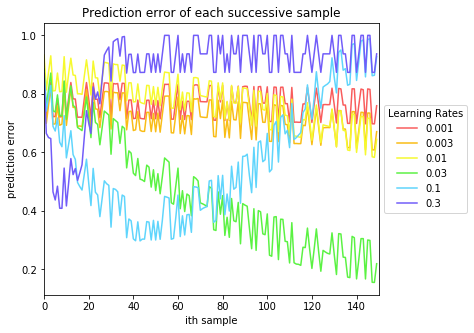

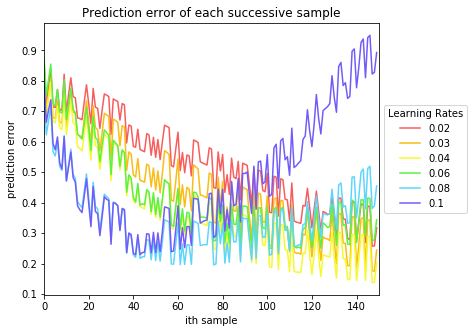

In [142]:
# plot for these learning rates
learning_rates = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3]
shape = [4, 5, 1] # default shape (nodes per layer: [input_layer, hidden_layer, output_layer])
plot_trials(NeuralNetwork(shape), learning_rates=learning_rates)

# The 0.03 and 0.1 learning rates above do best, try other close numbers
plot_trials(NeuralNetwork(shape), \
                    learning_rates=[0.02, 0.03, 0.04, 0.06, 0.08, 0.1])

The best-performing learning rate is around 0.04, given the number of samples used for training.  Slower learning rates arrive at a better prediciton error, but need more samples.  With high learning rates, gradient descent appears to trend toward a minimum before moving out and diverging.

Order of appearance of the samples remains the same across all trials.  Outcomes vary somewhat because weights are randomly initialized.

### Varing the decay rate (of the weights)

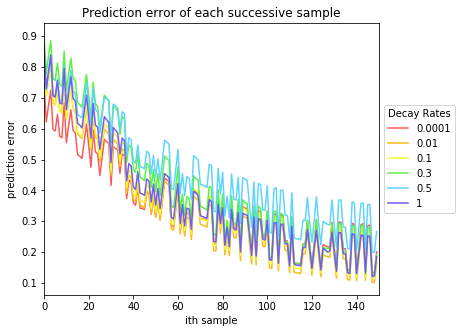

In [143]:
learning_rate = 0.04 # was the best-performing learning rate
decay_rates = [0.0001, 0.01, 0.1, 0.3, 0.5, 1]

plot_trials(NeuralNetwork(shape,learning_rate=learning_rate),\
                    decay_rates=decay_rates)

Inconclusive.

### Varying hidden layer size

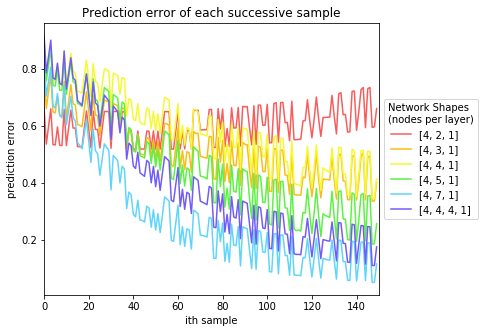

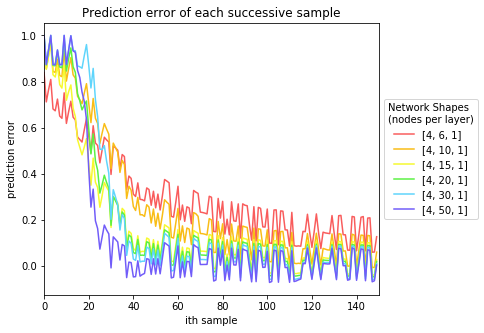

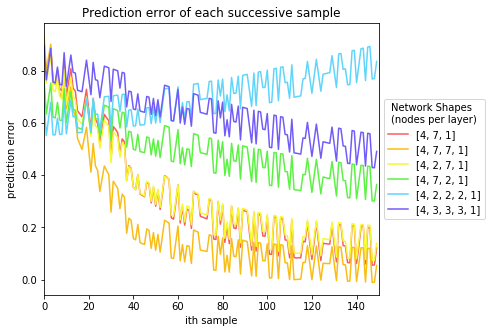

In [144]:
learning_rate = 0.04
decay_rate = 0
shapes = [[4,2,1],
          [4,3,1],
          [4,4,1],
          [4,5,1],
          [4,7,1],
          [4,4,4,1]]

plot_trials(NeuralNetwork(shape, learning_rate=learning_rate, decay_rate=decay_rate),\
                    shapes=shapes)

shapes = [[4,6,1],
          [4,10,1],
          [4,15,1],
          [4,20,1],
          [4,30,1],
          [4,50,1]]

plot_trials(NeuralNetwork(shape, learning_rate=learning_rate, decay_rate=decay_rate),\
                    shapes=shapes)

shapes = [[4,7,1],
          [4,7,7,1],
          [4,2,7,1],
          [4,7,2,1],
          [4,2,2,2,1],
         [4,3,3,3,1]]

plot_trials(NeuralNetwork(shape, learning_rate=learning_rate, decay_rate=decay_rate),\
                    shapes=shapes)



#### Analysis<a name="analysis"></a>
The best-performing shape was a single hidden layer with a high number of nodes (20).  After about 20, there are diminished returns increasing this number.

For this dataset, introducing another hidden layer seemed to help somewhat only if both layers were large. Two hidden layers of size 7 peformed about as well as one layer of size 20.

I used up to 50 hidden nodes in a single hidden layer and the prediction error didn't trend back upward.  This non-increase doesn't apply for multiple hidden layers.  It appears that the best parameterizations are interdependent and dataset specific.

### Resources <a name="resources"></a>
Websites I found helpful in understanding the project:
- [wild machine learning blog](http://www.wildml.com/) - clarified backpropgation & gradient checking
- [machine learning coursera, Andrew Ng, support wiki](http://mlwiki.org/index.php/Neural_Networks#Neural_Networks) - shed light on different cost function
- [Cross-entropy cost function derivation](http://neuralnetworksanddeeplearning.com/chap3.html) - walk through derivation of the cost function & fully understand back propogation
- [Activation Functions Explained](https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6) - used the sigmoid function graphic